# Analysis of the autism data

Template exp:
Records n 7 

In [8]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


# Retrieve experiments results

In [ ]:
from utils import create_autism_df
def compute_SD(AUC, N1, N2):
    Q1=AUC/(2-AUC)
    Q2 = 2*AUC*AUC/(1+AUC)
    return(np.sqrt((AUC*(1-AUC)+(N1-1)*(Q1-AUC*AUC) + (N2-1)*(Q2-AUC*AUC))/(N1*N2)))

df = create_autism_df(folder_names = ['8_December'])#'13_november_bis'])#'November 2022'])
df['Hanley_CI'] = df['AUROC'] .apply(lambda x: compute_SD(x, 417, 50))
df['tree_usage'] = df['tree_usage'].apply(lambda x: np.mean(x))

 67%|██████▋   | 1235/1851 [05:41<02:49,  3.63it/s]

In [ ]:
df.to_csv('/home01/sam/notes_on_stats/doc/src/data/8_December/recap.csv', index=False)

In [4]:
results_df_vertical = pd.DataFrame(columns = ['experiment_name', 'imputation_method', 'missing_data_handling', 'scale_data', 'n_features', 
                                              'sampling_method', 'max_depth',  'gamma', 'reg_lambda', 'learning_rate', 'n_estimators',
                                              'score', 'metric_name', 'TP', 'TN', 'FP', 'FN', 'y_true', 'y_pred', 'Hanley_CI'])

metrics_of_interest = ['AUROC', 'F1 score Corrected', 'Sensitivity', 'Specificity','PPV-Corr', 'TP', 'TN', 'FP', 'FN', 'Hanley_CI']
metrics_to_plot = ['AUROC', 'F1 score Corrected', 'Sensitivity', 'Specificity', 'PPV-Corr']#, 'Precision Corrected']

for exp, experiment_row in df.iterrows():
    
    for metric in metrics_of_interest:
        
        results_df_vertical = results_df_vertical.append({'experiment_name':experiment_row['experiment_name'], 
                                                                       'imputation_method':experiment_row['imputation_method'], 
                                                                       'missing_data_handling':experiment_row['missing_data_handling'], 
                                                                       'scale_data':experiment_row['scale_data'], 
                                                                       'n_features': experiment_row['n_features'], 
                                                                       'sampling_method': experiment_row['sampling_method'], 
                                                                       'max_depth': experiment_row['max_depth'], 
                                                                       'n_estimators': experiment_row['n_estimators'], 
                                                                       'gamma': experiment_row['gamma'], 
                                                                       'reg_lambda': experiment_row['reg_lambda'], 
                                                                       'learning_rate': experiment_row['learning_rate'], 
                                                                       'score':experiment_row[metric], 
                                                                       'metric_name':metric,
                                                                       'TP':experiment_row['TP'], 
                                                                       'TN':experiment_row['TN'], 
                                                                       'FP':experiment_row['FP'], 
                                                                       'y_true': [experiment_row['y_true']], 
                                                                       'y_pred': [experiment_row['y_pred']], 
                                                                       'Hanley_CI': experiment_row['Hanley_CI'], 
                                                                      }, ignore_index=True)
        
results_df_vertical.loc[results_df_vertical['metric_name']!='AUROC', 'Hanley_CI'] = 0

In [41]:
df = df.append(pd.DataFrame({'experiment_name': 'EyeTracker', 
                             'Specificity': .98, 
                             'Sensitivity':.17 , 
                             'PPV': .81, 
                             'NPV': .65
                            }, index=[0]))



##### Ploting Functions

In [5]:
def plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False, savefig=False):
    
    colors = plt.get_cmap('tab10')(np.arange(0,20))

    
    if xtickslabels is None:
        xtickslabels = sorted(results[condition].unique())
        
    if order is None:
        order = sorted(results[condition].unique())
        
    else:
        xtickslabels = order


    fig = plt.figure(figsize=(25, 8));ax = plt.gca()
    # loop over the curves (i.e. the metrics to be plotted)
    for j, metric_name in enumerate(results['metric_name'].unique()):

        color = colors[j]
        # loop over the x ticks  (i.e. the condition that is varying)
        for i, condition_value in enumerate(order):

            plt.errorbar([i], 
                     results[(results['metric_name']==metric_name) &
                                (results[condition]==condition_value)]['score'].mean(),
                     yerr=results[(results['metric_name']==metric_name) &
                                (results[condition]==condition_value)]['score'].std(), 
                     fmt='',
                     ecolor=color,
                    # ecolor=color,
                     alpha=.5, 
                     capthick=2,
                     elinewidth=5,
                     capsize=15)
            plt.scatter([i], 
                     results[(results['metric_name']==metric_name) &
                                (results[condition]==condition_value)]['score'].mean(),
                     marker='o',
                     s=100,
                     label=metric_name if i==0 else None, color=color)


    plt.grid(); plt.title("Performances when using or not the inidcator variables", weight='bold')
    #plt.ylabel(metric_name, weight='bold');
    plt.xlabel(condition, weight='bold');plt.xlim([-1, len(results[condition].unique())]); plt.ylim([-0.02, 1.02])
    plt.xticks(np.arange(len(results[condition].unique())), xtickslabels, rotation=90 if rotate else 0);plt.legend()
    if savefig:
        os.makedirs(os.path.join(DATA_DIR, 'figures'), exist_ok=True)
        plt.savefig(os.path.join(DATA_DIR, 'figures', savefig+'.png'), dpi=200, bbox_inches = 'tight')
            


    fig = plt.figure(figsize=(25, 5));ax = plt.gca()
    ax = sns.pointplot(data=results, x=condition, y="relative_score", hue='metric_name', hue_order=results['metric_name'].unique(), ci='sd', linestyles='-', ax = ax)
    ax.set_title("Performances gain", weight='bold')
    ax.axhline([0], color='tab:red', linestyle='-.');ax.legend(prop={'size':18})
    
    return

# 1) Model developemnt

## Influence of adding the indicator variables

In [6]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'use_Z') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]

results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan
for idx, row in results.iterrows():
    baseline_score = results.loc[(results['n_features']==20) & (results['metric_name']==row['metric_name']), 'score'].item()
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)/baseline_score*100

condition = 'n_features'
xtickslabels = ['Without Z', 'With Z']
plot_scatter_results(results, condition, xtickslabels)
    

ValueError: can only convert an array of size 1 to a Python scalar

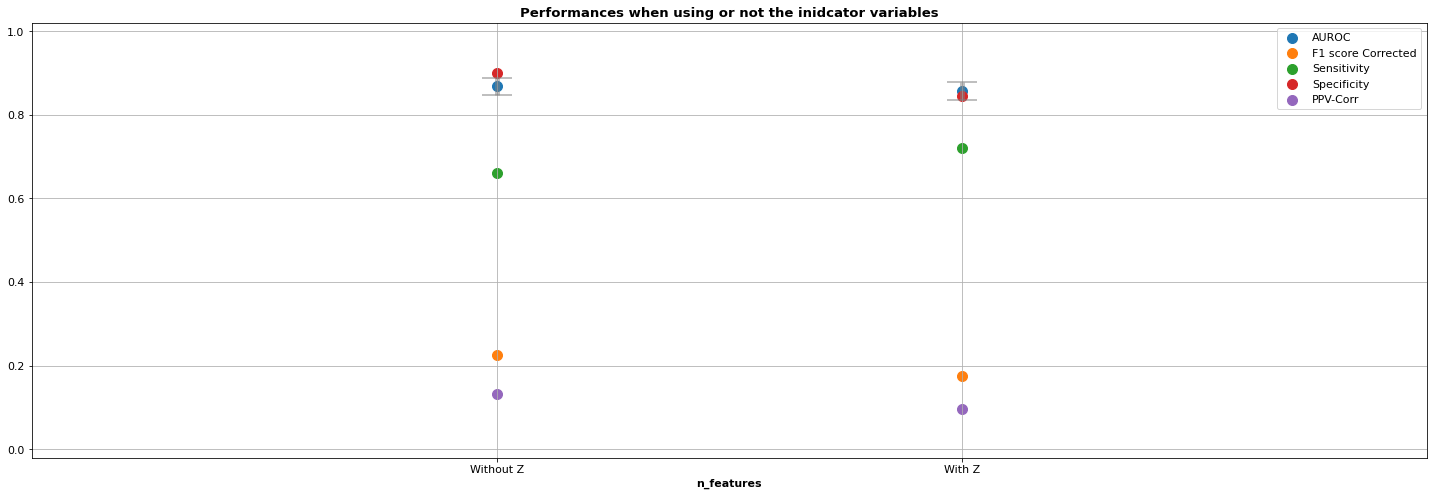

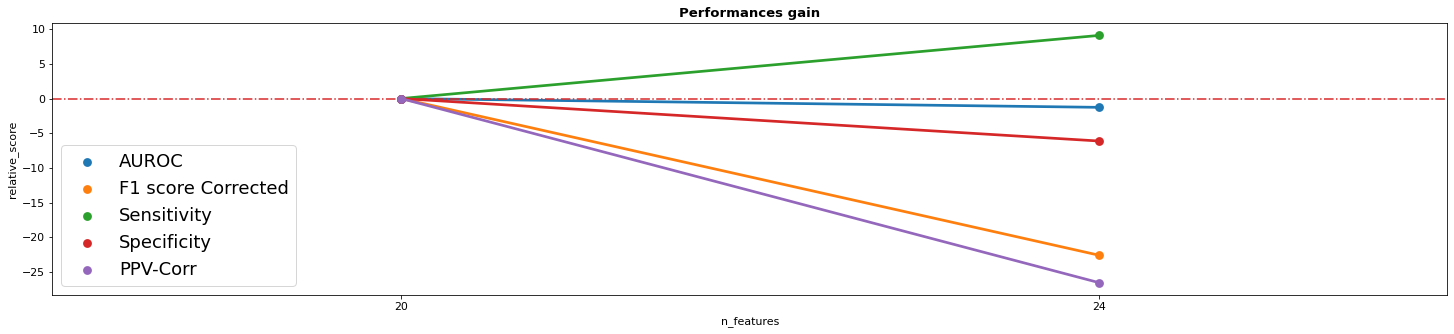

In [71]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'use_Z') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]

results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan
for idx, row in results.iterrows():
    baseline_score = results.loc[(results['n_features']==20) & (results['metric_name']==row['metric_name']), 'score'].item()
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)/baseline_score*100

condition = 'n_features'
xtickslabels = ['Without Z', 'With Z']
plot_scatter_results(results, condition, xtickslabels)
    

**Conclusion**
- Using the additional indicator variables does not seem to improve the performances. 


## Influence of scaling the data

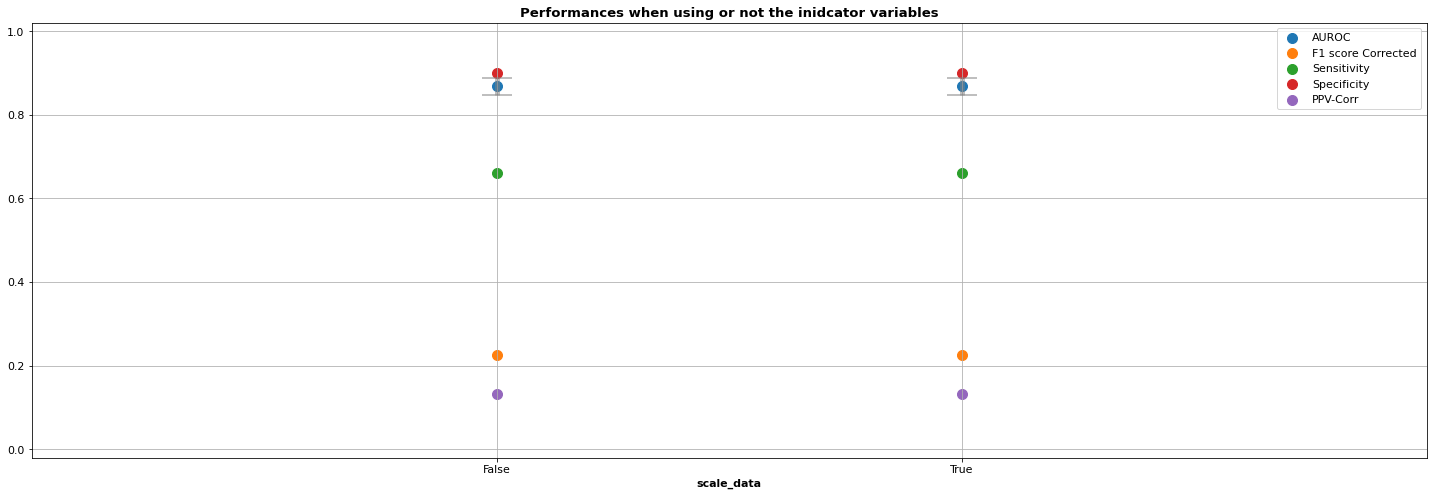

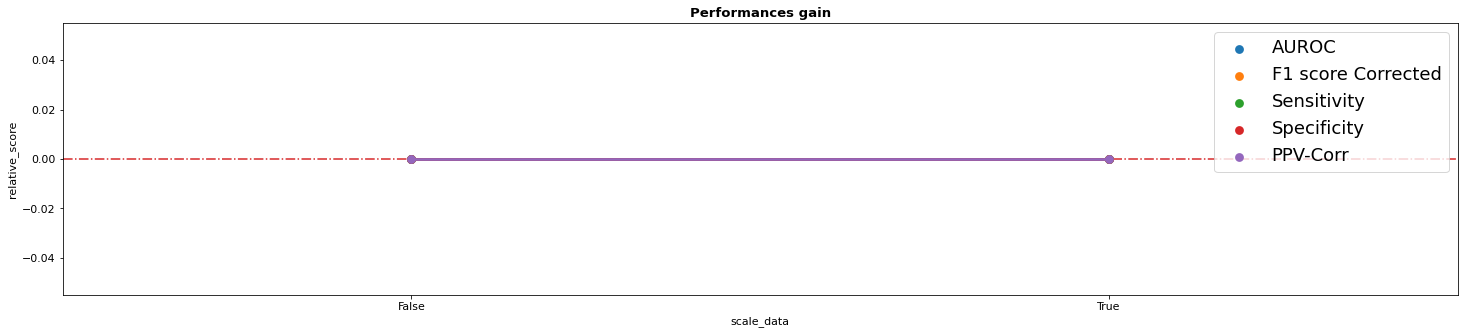

In [72]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'Scale Data') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]

results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan
for idx, row in results.iterrows():
    baseline_score = results.loc[(results['scale_data']==False) & (results['metric_name']==row['metric_name']), 'score'].item()
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)/baseline_score*100

condition = 'scale_data'
plot_scatter_results(results, condition)
    

## Influence of the sampling method

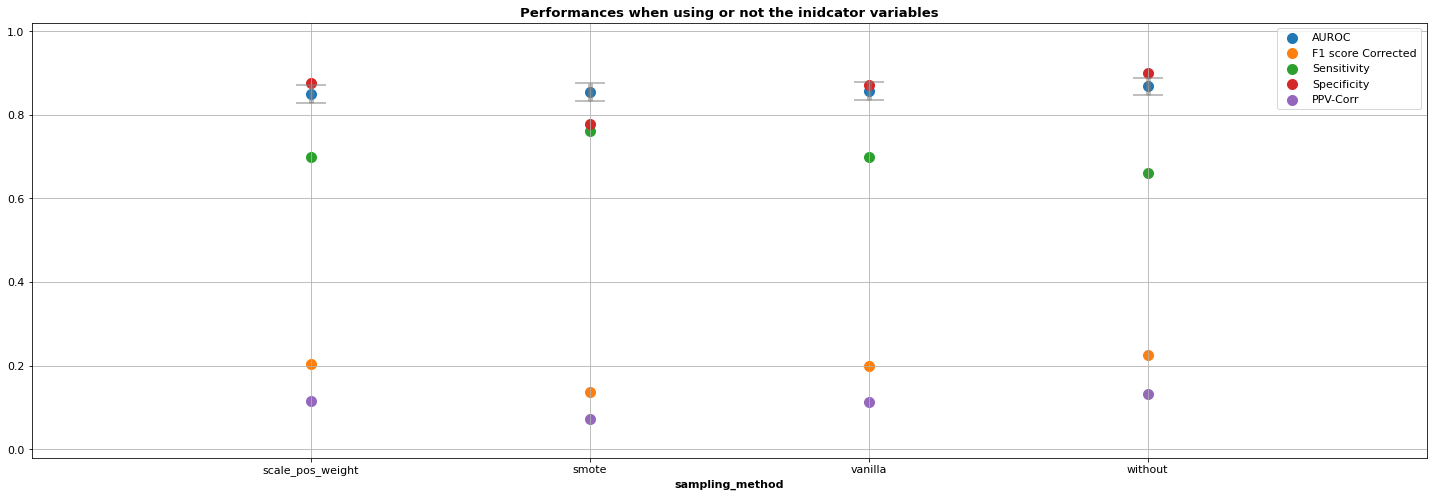

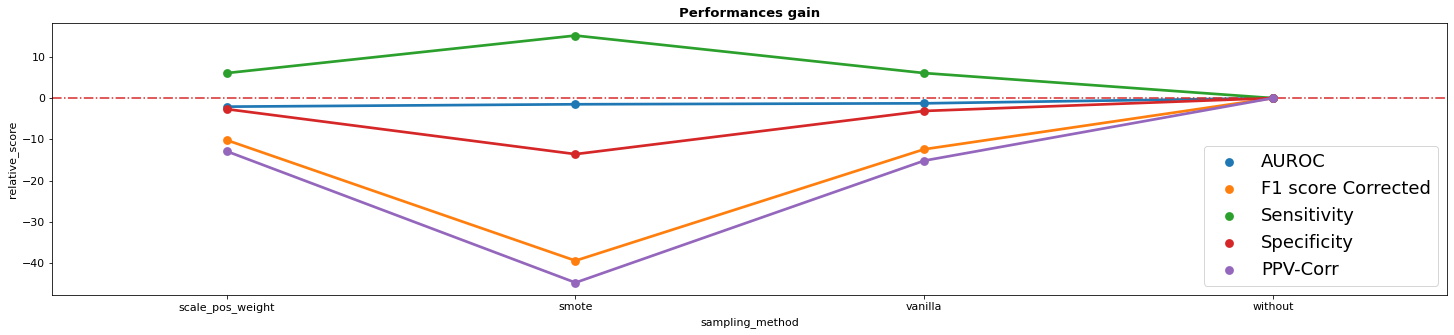

In [73]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'Sampling')& (results_df_vertical['metric_name'].isin(metrics_to_plot))]

results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    baseline_score = results.loc[(results['sampling_method']=='without') &(results['metric_name']==row['metric_name']), 'score'].item()
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)/baseline_score*100
    
    
condition = 'sampling_method'
plot_scatter_results(results, condition, xtickslabels=None)
    

**Conclusion**
- Using scale_pos_weight


## Influence of the imputation technics

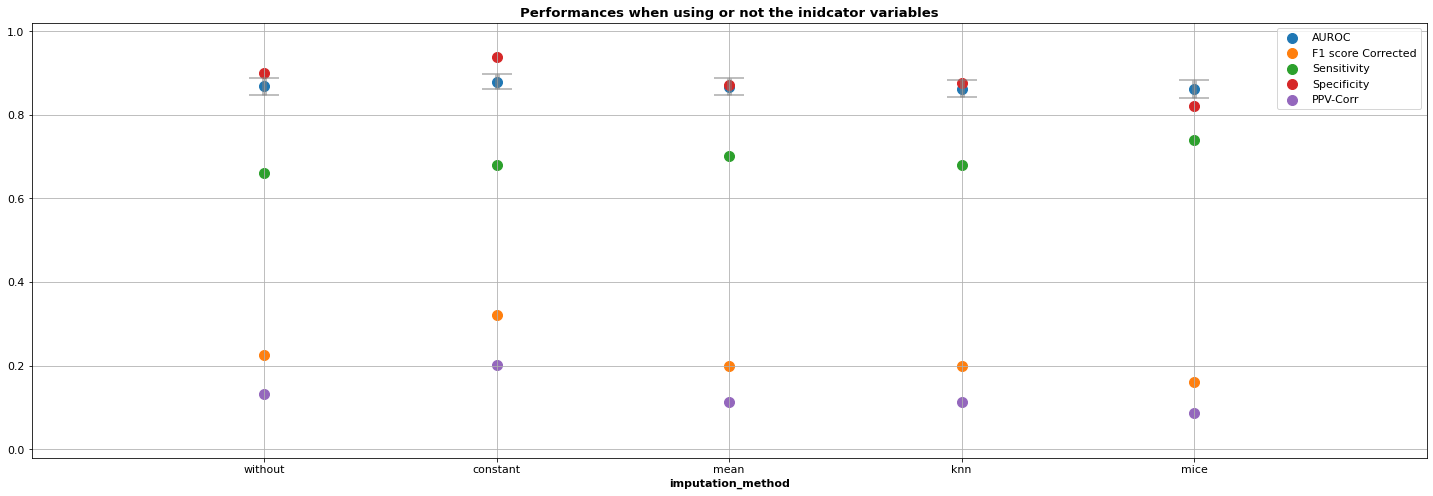

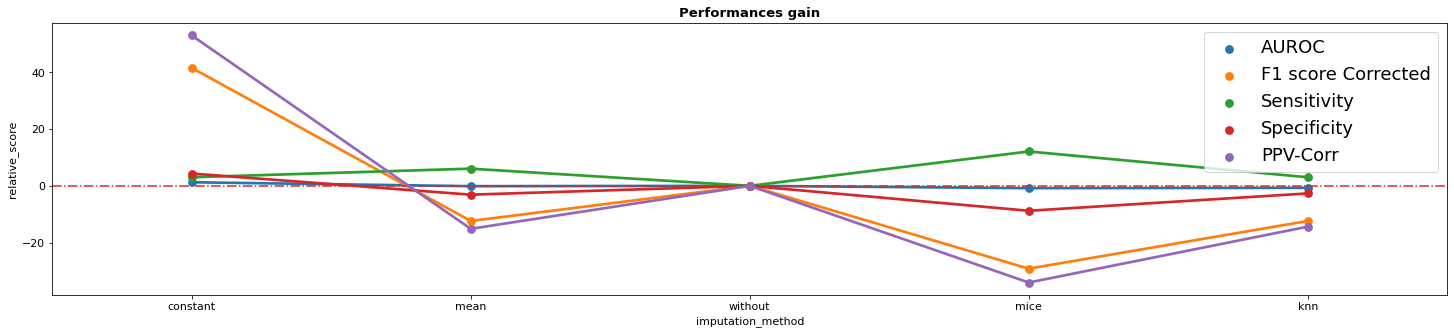

In [74]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'Imputation') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    baseline_score = results.loc[(results['imputation_method']=='without') &(results['metric_name']==row['metric_name']), 'score'].item()
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)/baseline_score*100

order = ['without', 'constant', 'mean', 'knn', 'mice']


condition = 'imputation_method'
plot_scatter_results(results, condition, xtickslabels=None, order=order)
    

**Conclusion**
- Constant imputation seem to improve the performances. Since then it's more difficult to retrieve the role of missing data, we will keep no imputation for now, but once the model is selected we will do another try to see the performances improvement.


## Influence of lambda

Text(0.5, 1.0, 'Tree usage (ratio of maximum number of posible leaves)')

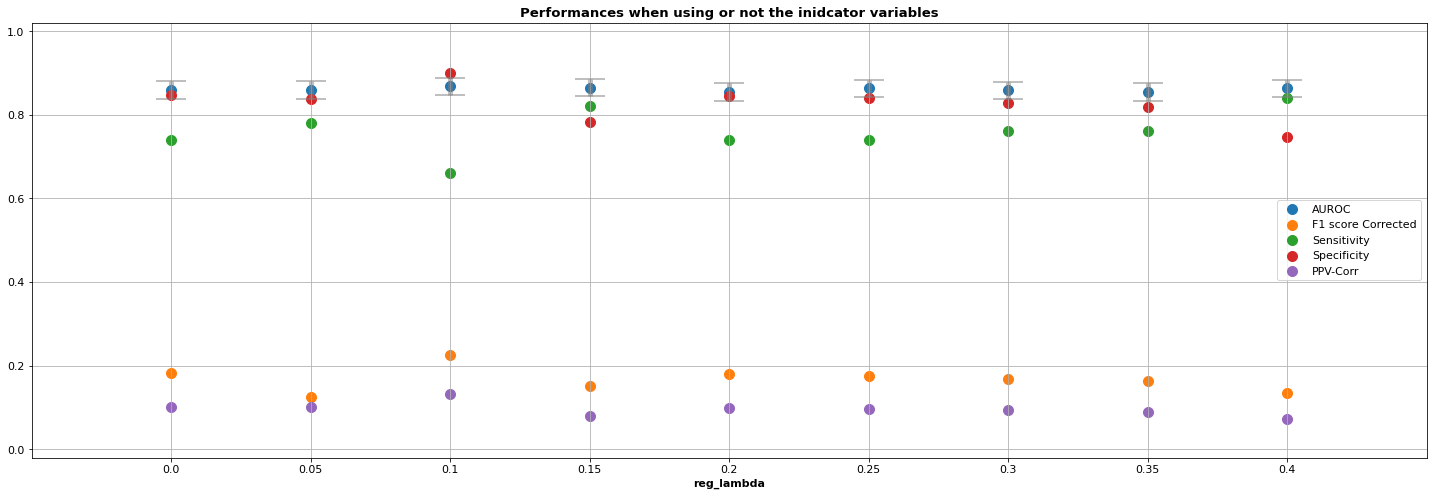

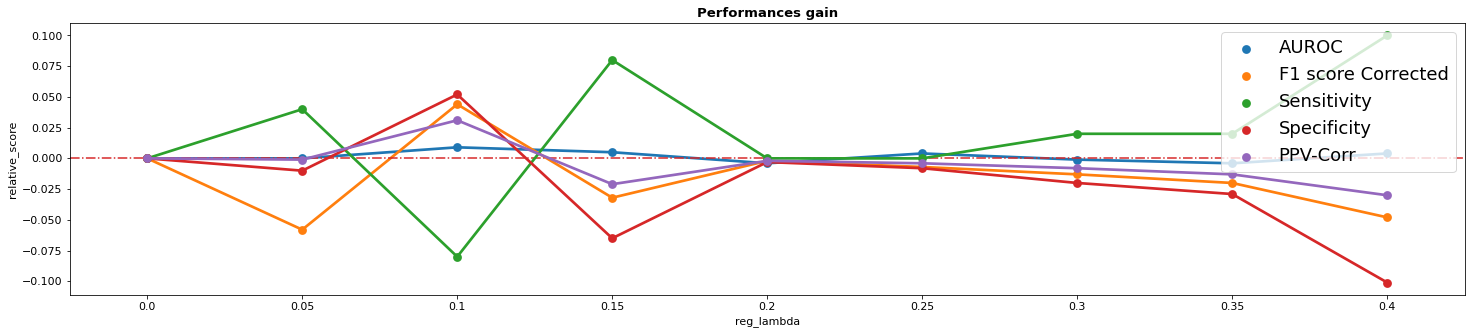

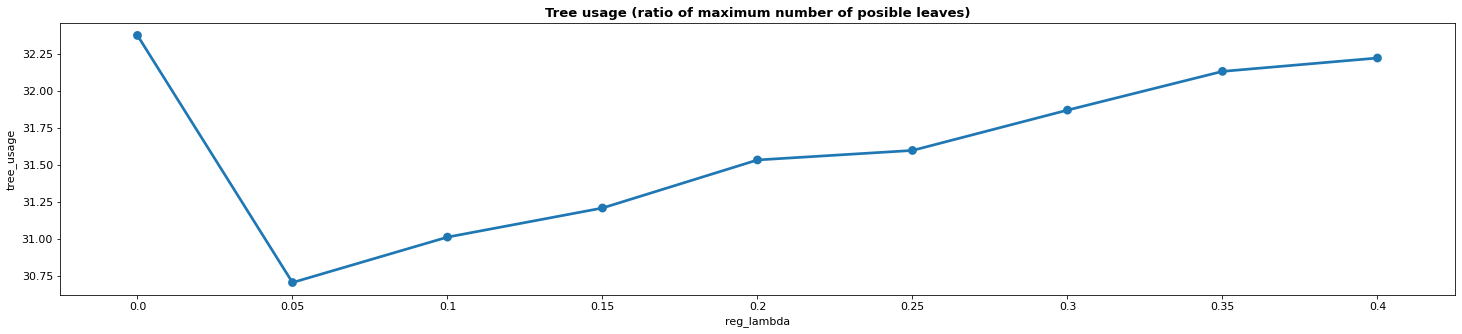

In [75]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'reg_lambda') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    
    baseline_score = results.loc[(results['reg_lambda']==0) &(results['metric_name']==row['metric_name']), 'score'].item()
    
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)#/baseline_score*100


condition = 'reg_lambda'
plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False)
    
fig = plt.figure(figsize=(25, 5));ax = plt.gca()
ax = sns.pointplot(data=df[df['experiment_name']==condition], x=condition, y="tree_usage", ci='sd', linestyles='-', ax = ax)
ax.set_title("Tree usage (ratio of maximum number of posible leaves)", weight='bold')

## Influence of the depth

Text(0.5, 1.0, 'Tree usage (ratio of maximum number of posible leaves)')

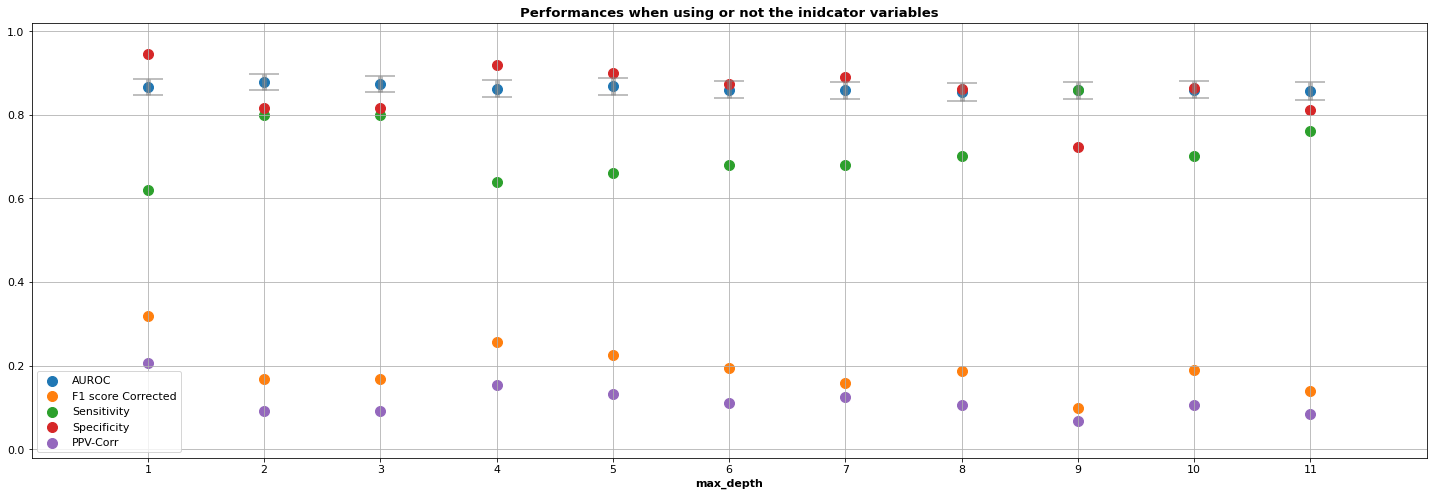

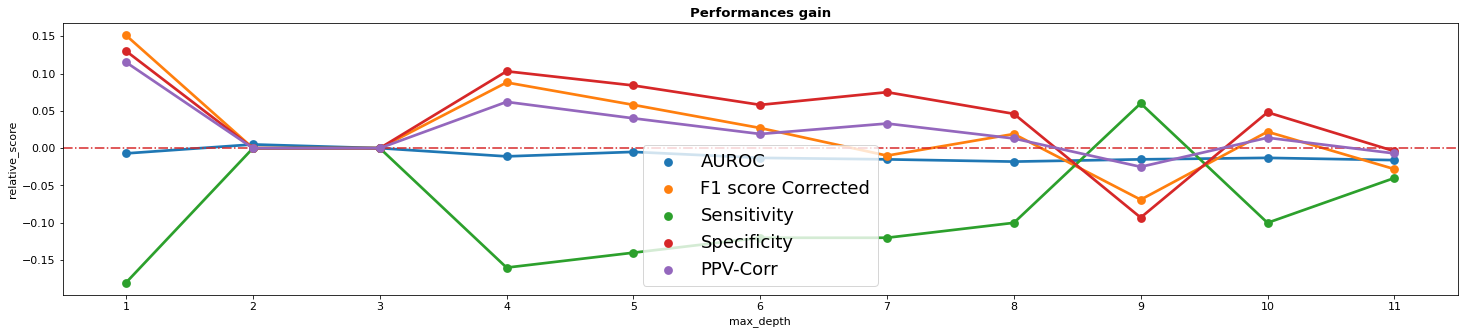

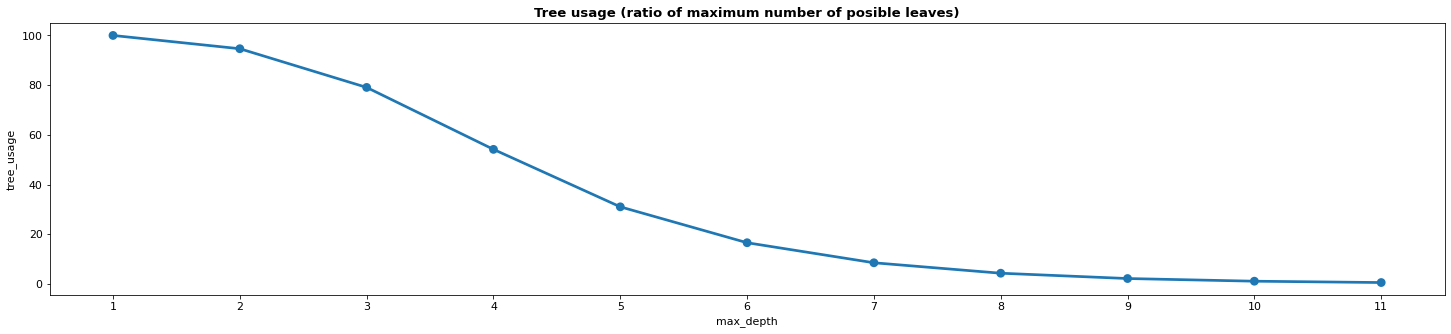

In [76]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'max_depth') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    
    baseline_score = results.loc[(results['max_depth']==3) &(results['metric_name']==row['metric_name']), 'score'].item()
    
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)#/baseline_score*100


condition = 'max_depth'
plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False)
    
fig = plt.figure(figsize=(25, 5));ax = plt.gca()
ax = sns.pointplot(data=df[df['experiment_name']==condition], x=condition, y="tree_usage", ci='sd', linestyles='-', ax = ax)
ax.set_title("Tree usage (ratio of maximum number of posible leaves)", weight='bold')

## Influence of the gamma

Text(0.5, 1.0, 'Tree usage (ratio of maximum number of posible leaves)')

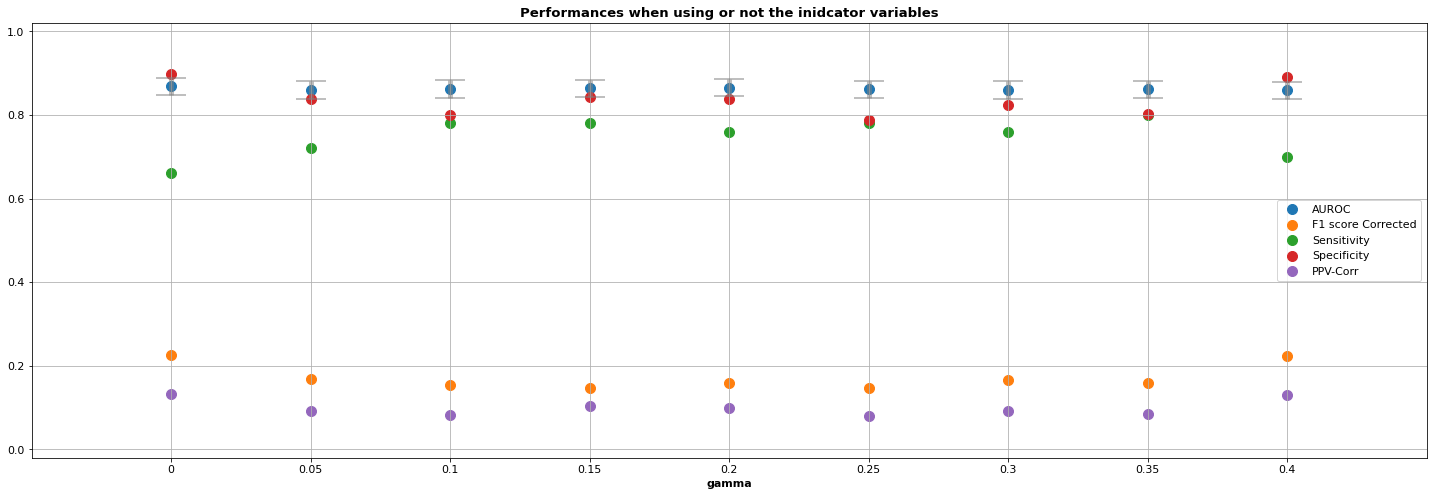

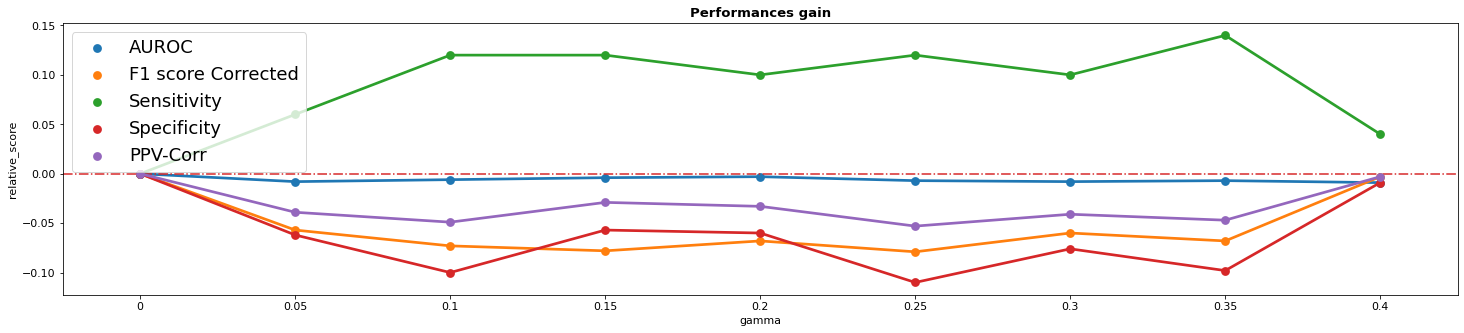

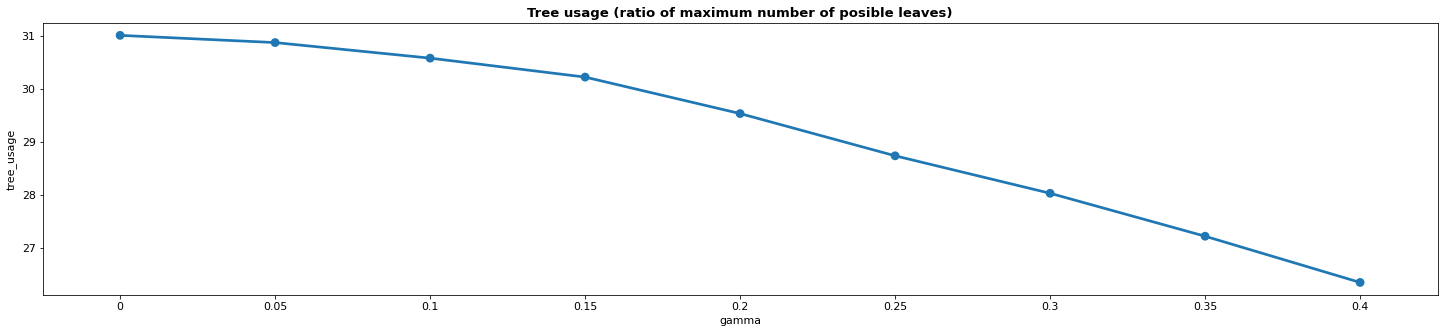

In [77]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'gamma') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    
    baseline_score = results.loc[(results['gamma']==0) &(results['metric_name']==row['metric_name']), 'score'].item()
    
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)#/baseline_score*100


condition = 'gamma'
plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False)
    
fig = plt.figure(figsize=(25, 5));ax = plt.gca()
ax = sns.pointplot(data=df[df['experiment_name']==condition], x=condition, y="tree_usage", ci='sd', linestyles='-', ax = ax)
ax.set_title("Tree usage (ratio of maximum number of posible leaves)", weight='bold')

## Influence of the learning rate

Text(0.5, 1.0, 'Tree usage (ratio of maximum number of posible leaves)')

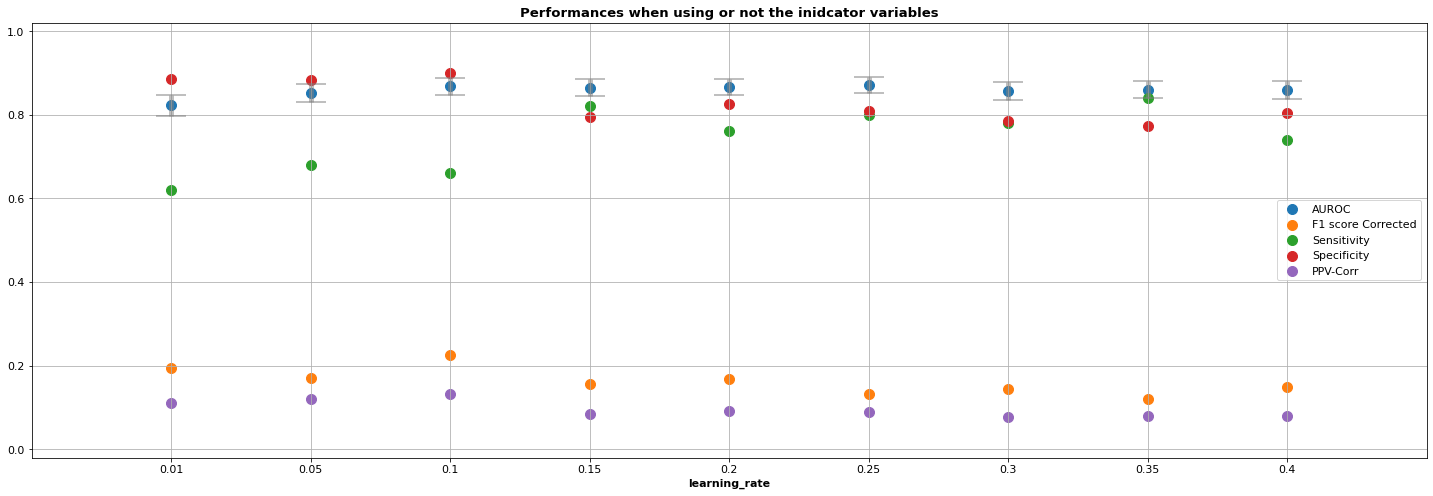

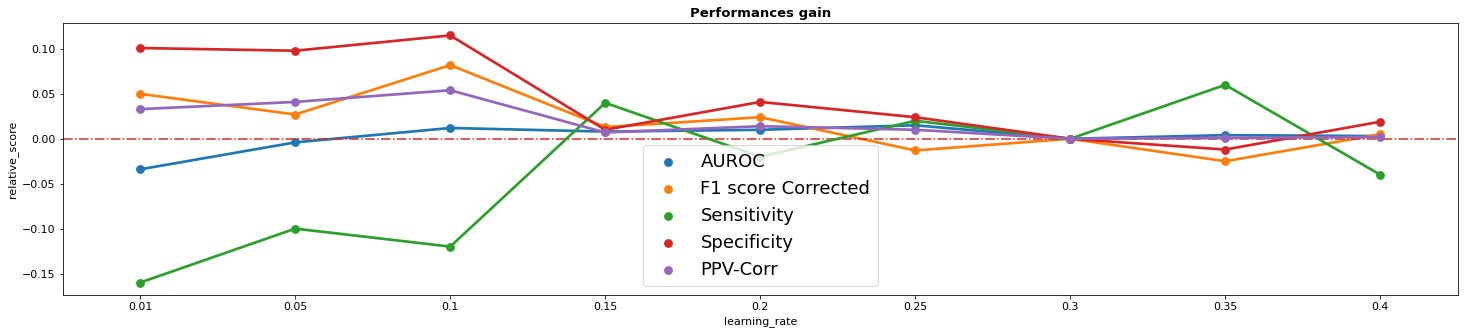

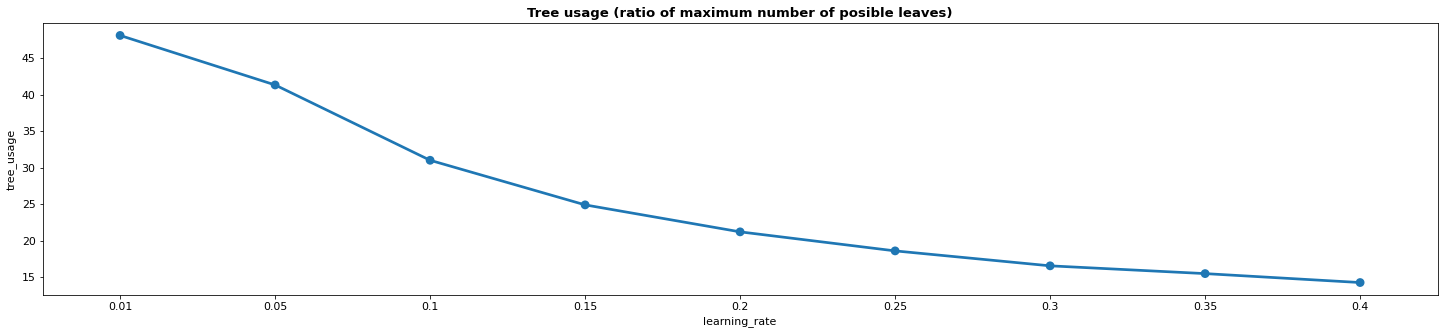

In [78]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'learning_rate') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    
    baseline_score = results.loc[(results['learning_rate']==.3) &(results['metric_name']==row['metric_name']), 'score'].item()
    
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)#/baseline_score*100
    
results.drop_duplicates(subset=['experiment_name', 'learning_rate', 'metric_name'], inplace=True)

condition = 'learning_rate'
plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False)
    
fig = plt.figure(figsize=(25, 5));ax = plt.gca()
ax = sns.pointplot(data=df[df['experiment_name']==condition], x=condition, y="tree_usage", ci='sd', linestyles='-', ax = ax)
ax.set_title("Tree usage (ratio of maximum number of posible leaves)", weight='bold')

## Influence of the n_estimators

Text(0.5, 1.0, 'Tree usage (ratio of maximum number of posible leaves)')

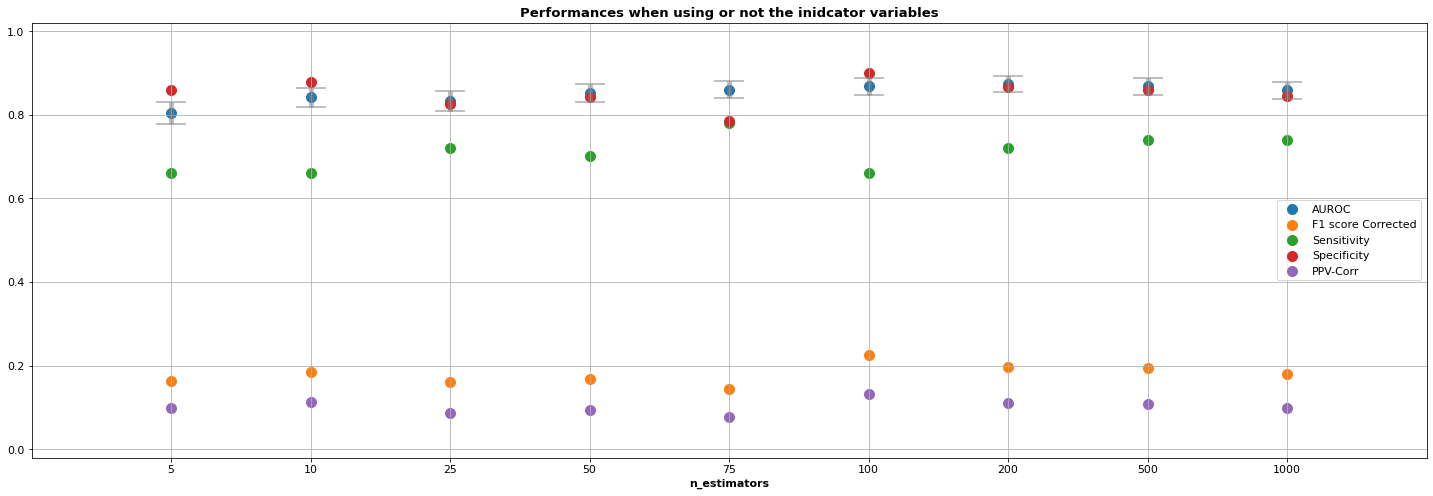

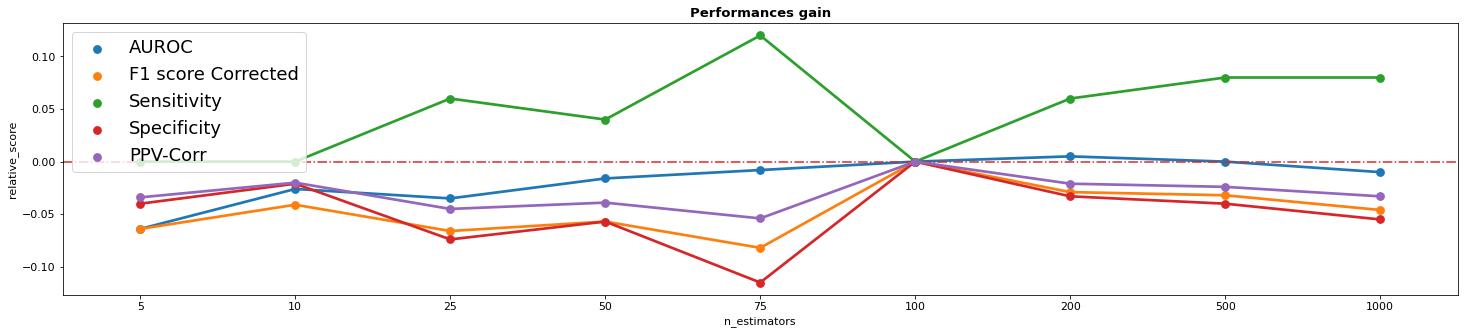

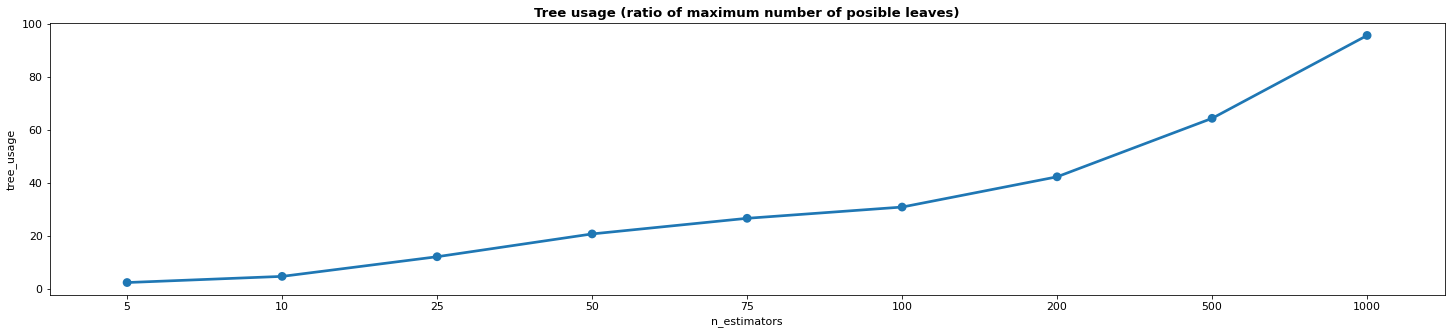

In [89]:
results = results_df_vertical[(results_df_vertical['experiment_name'] == 'n_estimators') & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    
    baseline_score = results.loc[(results['n_estimators']==100) &(results['metric_name']==row['metric_name']), 'score'].item()
    
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)#/baseline_score*100
    
condition = 'n_estimators'
plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False)
    
fig = plt.figure(figsize=(25, 5));ax = plt.gca()
ax = sns.pointplot(data=df[df['experiment_name']==condition], x=condition, y="tree_usage", ci='sd', linestyles='-', ax = ax)
ax.set_title("Tree usage (ratio of maximum number of posible leaves)", weight='bold')

## Conclusions

**Conclusions**

- Use Z
- No scaling
- lambda 0.1
- gamma 0.1
- Max depth 3
- n_estimators 200
- constant imputation
- learning rate 0.15
- scale_pos_weight

467 administrations left.


,id
diagnosis,
0.0,417
1.0,50


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Multimodal All,0.859,0.543,0.926,0.276,0.986,0.614,0.146,0.614,0.289,0.779,0.406,0.82,0.775,0.304,0.078,0.973,0.18,0.696,0.027,41,323,94,9


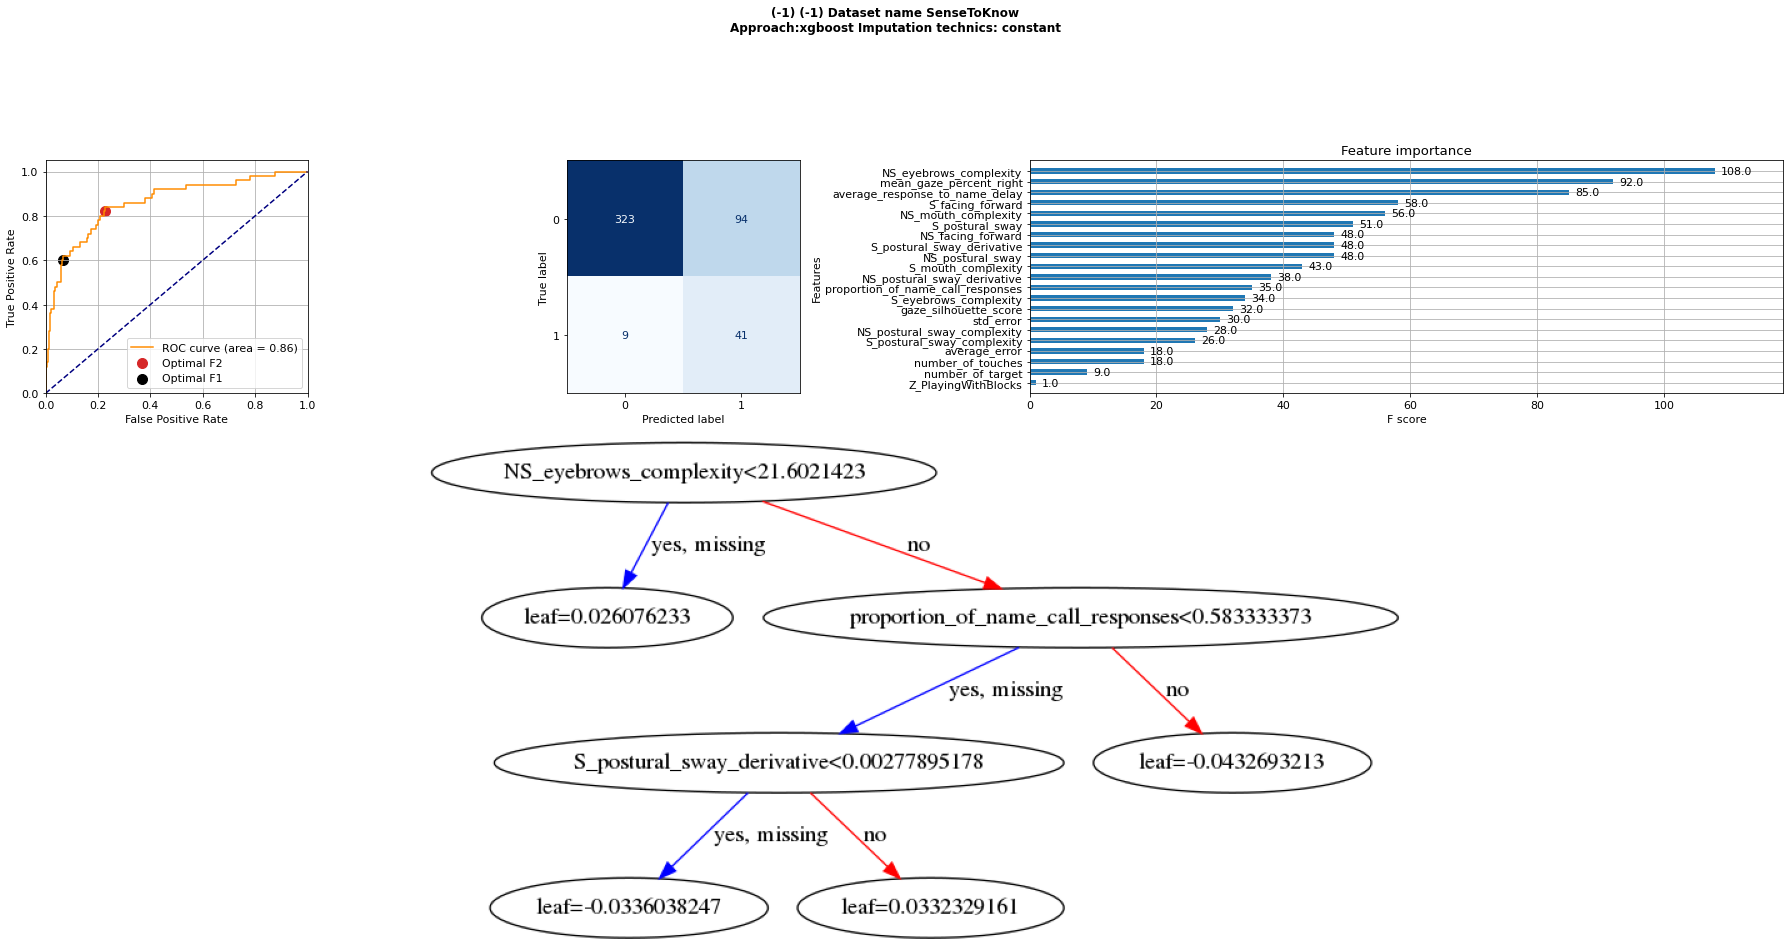

In [110]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 200,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}


df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='27_november', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'Multimodal All',
                  verbosity=1, 
                  save_experiment=False)

exp.fit_predict(num_cv='loocv')
exp.plot()

# Influence of calibration coefficient on the precision 

Since the positive class prevalence in the analyzed cohort might be different than the one in the population, the estimation of some performances metrics might be biased and lure scientists or decision makers. The precision estimates for instance can change drastically from the lab setting from the population implementation of a screening tools. This section aims at analyzing the evolution of the calibration factor $C(\pi)$ presented in (see [1]) in function of the study prevalence $\pi_{study}$.

$$\text{Precision}_{C} = \tfrac{TP}{TP + \tfrac{\pi_{lab}(1-\pi_{pop})}{\pi_{pop}(1-\pi_{lab})}FP}$$.

$$C(\pi_{lab}) =  \tfrac{\pi_{lab}(1-\pi_{pop})}{\pi_{pop}(1-\pi_{lab})} $$


[1] Siblini, W., Fréry, J., He-Guelton, L., Oblé, F., Wang, YQ. (2020). Master Your Metrics with Calibration. In: Berthold, M., Feelders, A., Krempl, G. (eds) Advances in Intelligent Data Analysis XVIII. IDA 2020. Lecture Notes in Computer Science(), vol 12080. Springer, Cham. https://doi.org/10.1007/978-3-030-44584-3_36

Text(0.5, 1.0, 'Evolution of the calibration coefficient in function of the study autism prevalence $\\pi_{study}$')

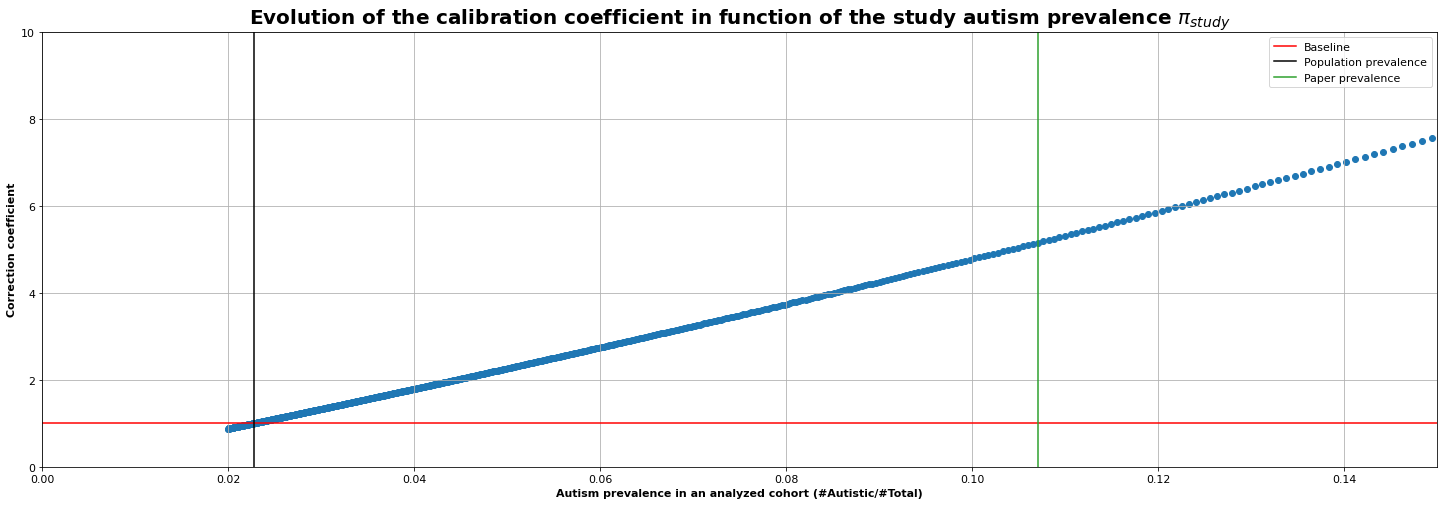

In [106]:
def coeff(pi):
    pi_0 = 1/44
    return (pi*(1-pi_0))/(pi_0*(1-pi))

pi_list = list(1/np.linspace(1, 50, 1000)) #From a prevalence of 1 (100% autistic) to a prevalence of 1/50 = 2%
coeff_list = [coeff(pi) for pi in pi_list]



fi(25, 8)
plt.scatter(np.array(pi_list), coeff_list)
plt.xlim([0, 0.15]);plt.ylim([0, 10])
plt.axhline(1, color='red', label='Baseline'); plt.ylabel("Correction coefficient", weight='bold');plt.xlabel("Autism prevalence in an analyzed cohort (#Autistic/#Total)", weight='bold')
plt.axvline(x=REFERENCE_IMBALANCE_RATIO, label='Population prevalence', color='k');plt.axvline(x=50/467, label='Paper prevalence', color='tab:green')
plt.legend();plt.grid()
plt.title("Evolution of the calibration coefficient in function of the study autism prevalence $\pi_{study}$", weight='bold', fontsize=20)